In [2]:
import sys
import os

# Get the current directory
current_directory = os.getcwd()

# Add the current directory to the Python path
sys.path.append(current_directory)
print(current_directory)

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import math
import re
import scipy
import tensorflow as tf
import seaborn as sns
import metrics
import socket #gets the machine name

#functionality to reload modules
import importlib
import spectraltools
# clear the import cache
importlib.reload(metrics)
importlib.reload(spectraltools)
# now you can import my_class and it'll be updated
from metrics import *
from spectraltools import *

#To avoid tf from crashing
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'


C:\Users\esteb\cicima\escarabajos\gamma


In [3]:
"""This section allows the user to choose their workplace location.
This is important if the user has multiple locations and operating systems in which this 
script is run"""

#Training data is used when we are already certain of species and genera for a particular sample
training_data_is_used = False

if socket.gethostname() == "colaboratory":
  from google.colab import drive
  drive.mount("/content/drive")
  #base folder
  """Select the location for your base folder"""
    
  base_folder = r"/content/drive/My Drive/CICIMA/escarabajos_files"
  
elif socket.gethostname() == "Shannon":

    """Select the location of your base folder"""
    base_folder = r"C:\Users\esteb\cicima\escarabajos"

elif socket.gethostname() == "CICIMA-EVSM":
  
    """Select the location of your base folder"""
    base_folder = r"C:\Users\EstebanSoto\Jupyter\escarabajos"

elif socket.gethostname() == "cicima_laptop":
    
    """Select the location of your base folder"""
    base_folder = r"/home/vinicio/escarabajos"

#define the location of the tables with information about the collections and its parent directory

collection_tables_main_path =  os.path.join(base_folder, "L1050_data","collections")
collection_files_main_path = os.path.join(base_folder, "L1050_data")

# Define report location
report_location = os.path.join(base_folder, "reports","data_analysis")

#collection_descriptor = r"CICIMAUCR and ANGSOL" tododelete

#File location and metadata location for collection 1
angsol_collection_path = os.path.join(collection_files_main_path,"ANGSOL","average") 
angsol_collection_metadata = os.path.join(collection_tables_main_path,"CICIMA-beetles-general-inventory - ANGSOL.txt") 

#File location and metadata location for collection 2
cicimaucr_collection_path = os.path.join(collection_files_main_path,r"TRA_data_CICIMA_INBUCR","CICIMAUCR","reflectance")  #listo
cicimaucr_collection_2_path = os.path.join(collection_files_main_path,r"CICIMA-2024-01-REFLECTANCE","average")
cicimaucr_collection_3_path = os.path.join(collection_files_main_path,r"CICIMA-2024-03-REFLECTANCE","without iris nor lens","average")
cicimaucr_collection_4_path = os.path.join(collection_files_main_path,r"CICIMA-2024-05-REFLECTANCE", "DORSAL","average")
#cicimaucr_collection_4_path = os.path.join(collection_files_main_path,r"CICIMA-2024-05-REFLECTANCE", "VENTRAL","average")
cicima_ucr_metadata = os.path.join(collection_tables_main_path,r"CICIMA-beetles-general-inventory - CICIMAUCR.txt") 

#File location and metadata location for collection 3
inbucr_collection_path = os.path.join(collection_files_main_path,r"INBUCR","average") #listo
inbucr_metadata = os.path.join(collection_tables_main_path,r"CICIMA-beetles-general-inventory - INBUCR.txt") 

#File location and metadata location for collection 4
bioucr_collection_path = os.path.join(collection_files_main_path,r"BIOUCR","average")  #listo
bioucr_metadata = os.path.join(collection_tables_main_path,r"CICIMA-beetles-general-inventory - BIOUCR.txt") 

#agregated data location, here averages and std will be saved when training data and retreived when classifying spectra
agregated_data_location = os.path.join(base_folder, "aggregated_data")

In [24]:
#Collections
angsol_collection = Specimen_Collection("ANGSOL", angsol_collection_path, angsol_collection_metadata, "HIGH")
angsol_collection.set_description("ANGSOL collection has specimens that belong to Angel Solís. The confidence that we have about specimen identification is high.")

cicimaucr_collection = Specimen_Collection("CICIMAUCR1", cicimaucr_collection_path, cicima_ucr_metadata, "HIGH")
cicimaucr_collection_2 = Specimen_Collection("CICIMAUCR2", cicimaucr_collection_2_path, cicima_ucr_metadata, "HIGH")
cicimaucr_collection_3 = Specimen_Collection("CICIMAUCR3", cicimaucr_collection_3_path, cicima_ucr_metadata, "HIGH")
cicimaucr_collection_3.set_description("""The most part of CICIMA specimens belongs to this collecttion""")

cicimaucr_collection_4 = Specimen_Collection("CICIMAUCR4", cicimaucr_collection_4_path, cicima_ucr_metadata, "HIGH")
cicimaucr_collection_4.set_description("""This collection has kalinini and resplendens specimens which were not used in training. 
                                        These are intended to be used as test subjects""")

inbucr_collection = Specimen_Collection("INBUCR", inbucr_collection_path, inbucr_metadata, "MID")
bioucr_collection = Specimen_Collection("BIOUCR", bioucr_collection_path, bioucr_metadata, "LOW")

collection_list = [
                    angsol_collection,
                    #cicimaucr_collection,
                    cicimaucr_collection_2,
                    cicimaucr_collection_3,
                    cicimaucr_collection_4,
                    inbucr_collection,
                    #bioucr_collection,
                    ]
collection_names_set = set([collection.name for collection in collection_list])
collection_names = " ".join( sorted(collection_names_set))

prediction_list = [
                    #angsol_collection,
                    #cicimaucr_collection,
                    #cicimaucr_collection_2,
                    #cicimaucr_collection_3,
                    #cicimaucr_collection_4,
                    #inbucr_collection,
                    bioucr_collection,
                    ]
prediction_collection_names_set = set([collection.name for collection in collection_list])
prediction_collection_names = " ".join( sorted(collection_names_set))


#print(collection_names)
#date
from datetime import datetime
current_date = datetime.now().date()

def get_filtered_spectra(collection_list):

    all_spectra = []
    
    for collection in collection_list:
        all_spectra += collection.get_spectra()

    all_spectra = [item for item in all_spectra if item.get_species() in ["kalinini", "resplendens", "cupreomarginata"]]
    all_spectra =  [item for item in all_spectra if item.code not in ["CICIMAUCR0070"]]
    return all_spectra
    
def get_spectra(collection_list):

    all_spectra = []
    
    for collection in collection_list:
        all_spectra += collection.get_spectra()

    return all_spectra  
    
training_spectra = get_filtered_spectra(collection_list)
prediction_spectra  = get_spectra(prediction_list) 

for spectrum in prediction_spectra:
    print(spectrum.get_species())

training_spectra

File: C:\Users\esteb\cicima\escarabajos\L1050_data\ANGSOL\average\ANGSOL0001.txt
File: C:\Users\esteb\cicima\escarabajos\L1050_data\ANGSOL\average\ANGSOL0002.txt
File: C:\Users\esteb\cicima\escarabajos\L1050_data\ANGSOL\average\ANGSOL0003.txt
File: C:\Users\esteb\cicima\escarabajos\L1050_data\ANGSOL\average\ANGSOL0004.txt
File: C:\Users\esteb\cicima\escarabajos\L1050_data\ANGSOL\average\ANGSOL0005.txt
File: C:\Users\esteb\cicima\escarabajos\L1050_data\ANGSOL\average\ANGSOL0006.txt
File: C:\Users\esteb\cicima\escarabajos\L1050_data\ANGSOL\average\ANGSOL0007.txt
File: C:\Users\esteb\cicima\escarabajos\L1050_data\ANGSOL\average\ANGSOL0008.txt
File: C:\Users\esteb\cicima\escarabajos\L1050_data\ANGSOL\average\ANGSOL0009.txt
File: C:\Users\esteb\cicima\escarabajos\L1050_data\ANGSOL\average\ANGSOL0010.txt
File: C:\Users\esteb\cicima\escarabajos\L1050_data\ANGSOL\average\ANGSOL0011.txt
File: C:\Users\esteb\cicima\escarabajos\L1050_data\ANGSOL\average\ANGSOL0012.txt
File: C:\Users\esteb\cicima\

#### System Information

In [25]:
import sys

float_info = sys.float_info
print("Floating point representation information:")
print("-----------------------------------------------------")
print("Smallest representable positive number:", float_info.min)
print("Largest representable finite number:", float_info.max)
print("Smallest positive x for which 1.0 + x != 1.0:", float_info.epsilon)
print("Number of digits in the significand (precision in digits):", float_info.dig)
print("Number of base-10 digits in the significand (precision in decimal digits):", float_info.mant_dig)
print("-----------------------------------------------------")

Floating point representation information:
-----------------------------------------------------
Smallest representable positive number: 2.2250738585072014e-308
Largest representable finite number: 1.7976931348623157e+308
Smallest positive x for which 1.0 + x != 1.0: 2.220446049250313e-16
Number of digits in the significand (precision in digits): 15
Number of base-10 digits in the significand (precision in decimal digits): 53
-----------------------------------------------------


In [26]:
def pad_list(lst, filler=0):
    metrics = lst[1]
    
    for metric in metrics:
        #print(metric)
        
        max_length = max([len(list) for list in metrics])
        
        #print(max_length)
        
        padded_list = []

        for element in metrics:

            padded_sublist = element
            
            padded_sublist += [filler] * (max_length - len(padded_sublist))
            padded_list.append(padded_sublist)
            #print(padded_sublist)
    final_list = [lst[0], (padded_list), lst[2]]
    return final_list

filtered_set length: 11 for species kalinini


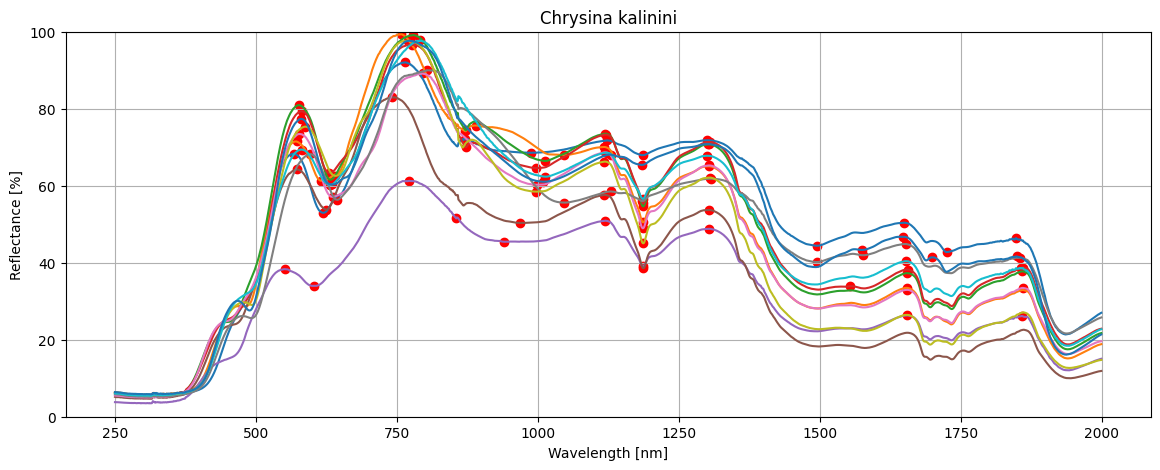

filtered_set length: 21 for species resplendens


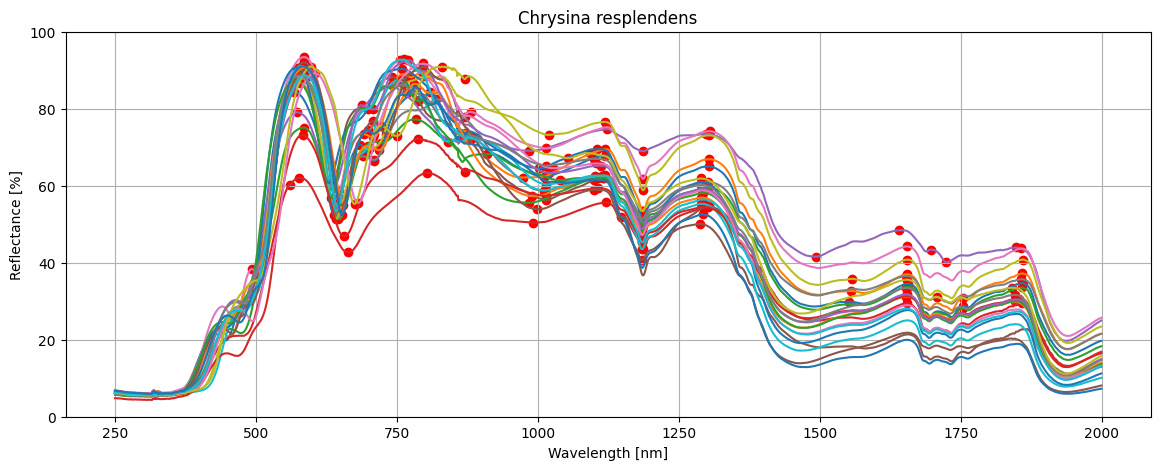

filtered_set length: 12 for species cupreomarginata


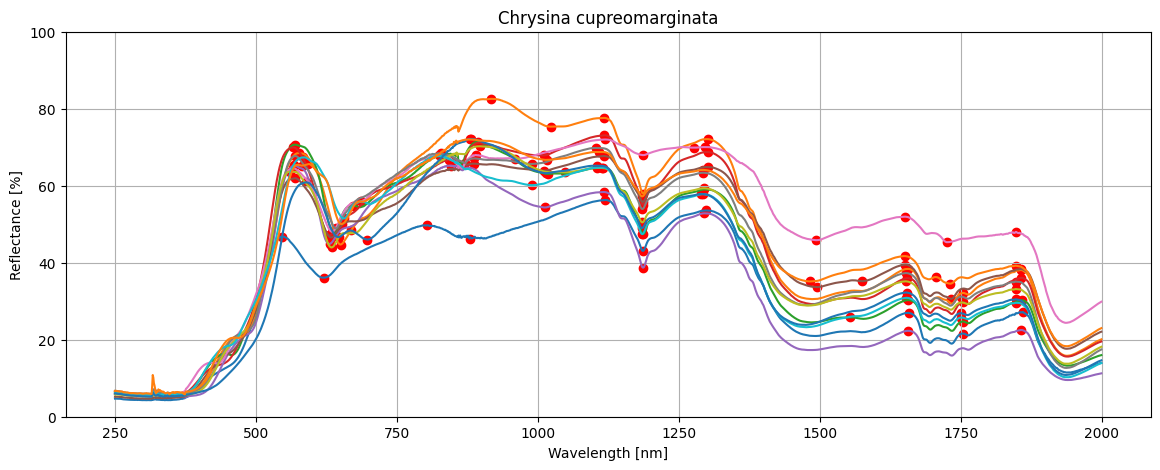

In [27]:
### Define species list
species_list = ["kalinini","resplendens", "cupreomarginata"]
for species in species_list:
    plt.figure(figsize = (14,5))
    filtered_set = [spectrum for spectrum in training_spectra if spectrum.species == species]
    filtered_set = [spectrum for spectrum in filtered_set if min(spectrum.data["wavelength"]) <= 250]
    filtered_set = [spectrum for spectrum in filtered_set if max(spectrum.data["wavelength"]) >= 1900]
    print(f"filtered_set length: {len(filtered_set)} for species {species}")
    for spectrum in filtered_set:
        peak_list = PeakList(spectrum)
        peak_list.plot_settings()
        #print(peak_list.get_peaks()) 
    plt.title(f"Chrysina {species}")
    plt.ylabel(f"Reflectance [%]")
    plt.xlabel(f"Wavelength [nm]")
    plt.grid()
    plt.ylim((0,100))
    plt.show()

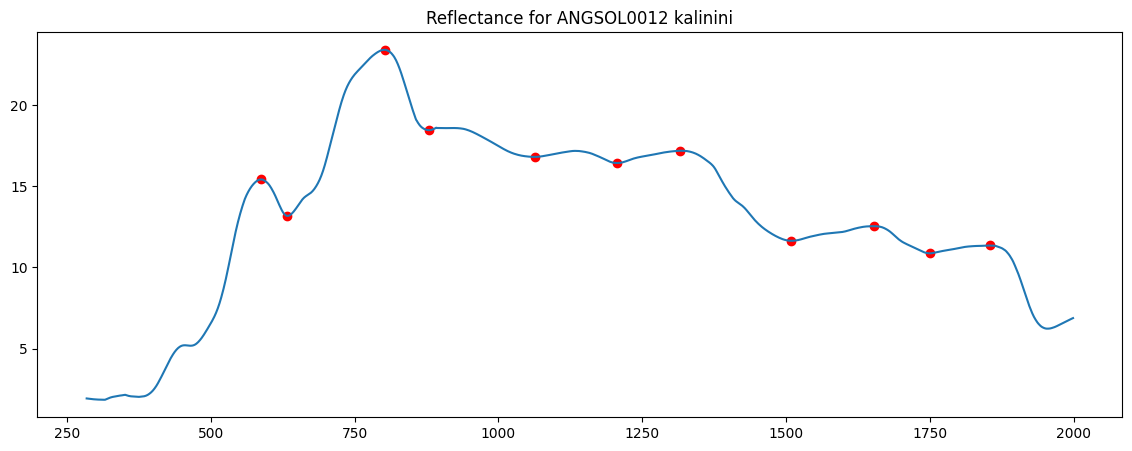

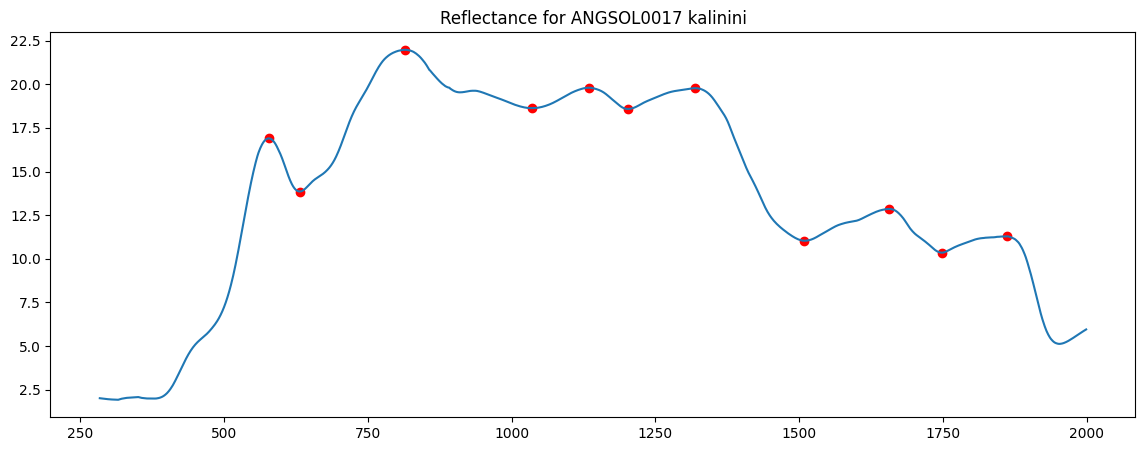

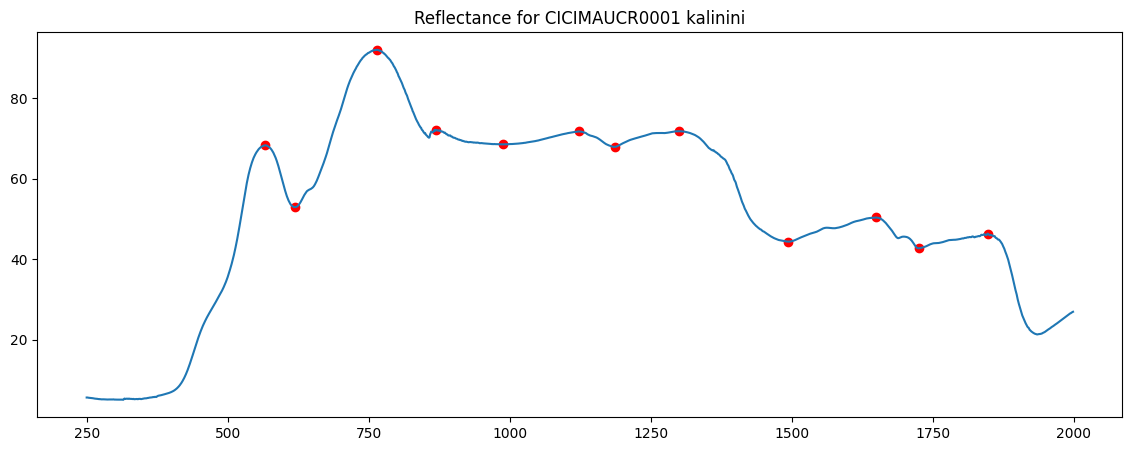

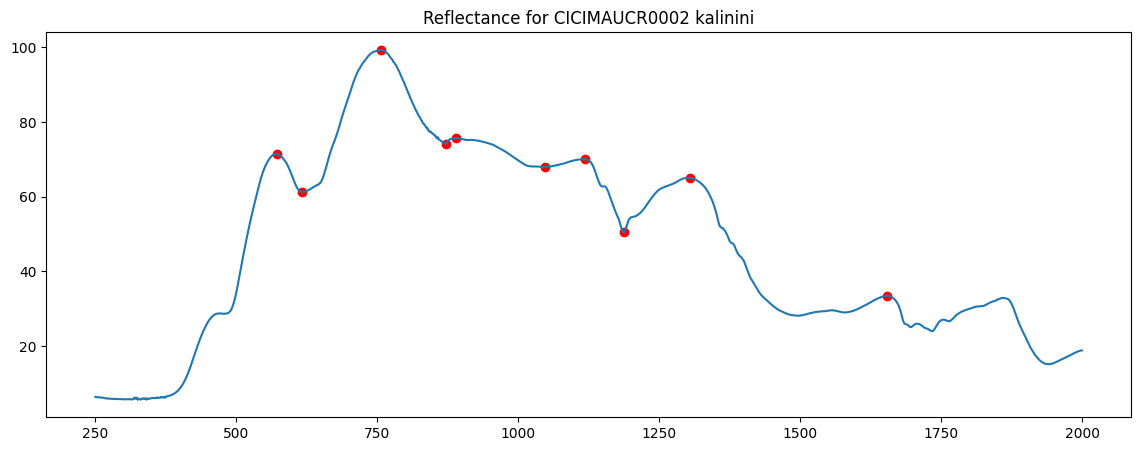

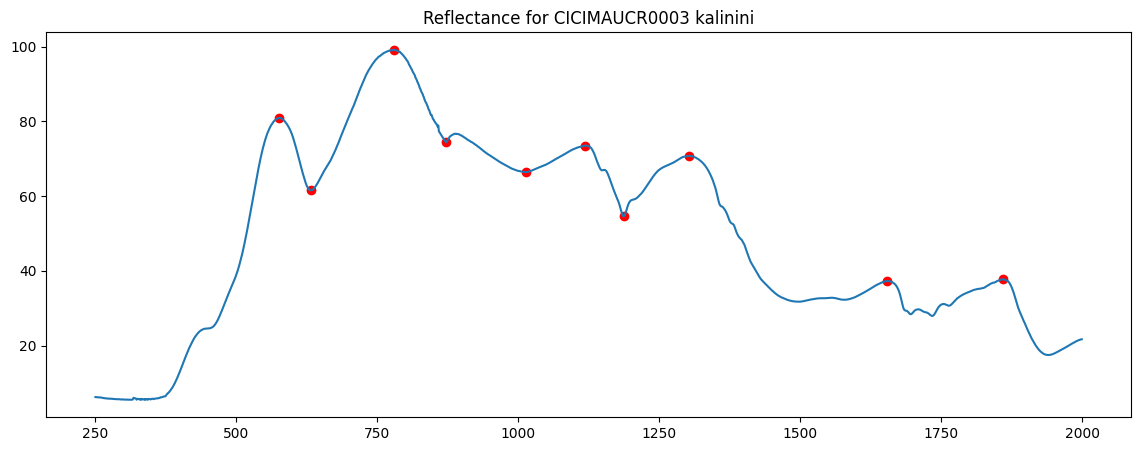

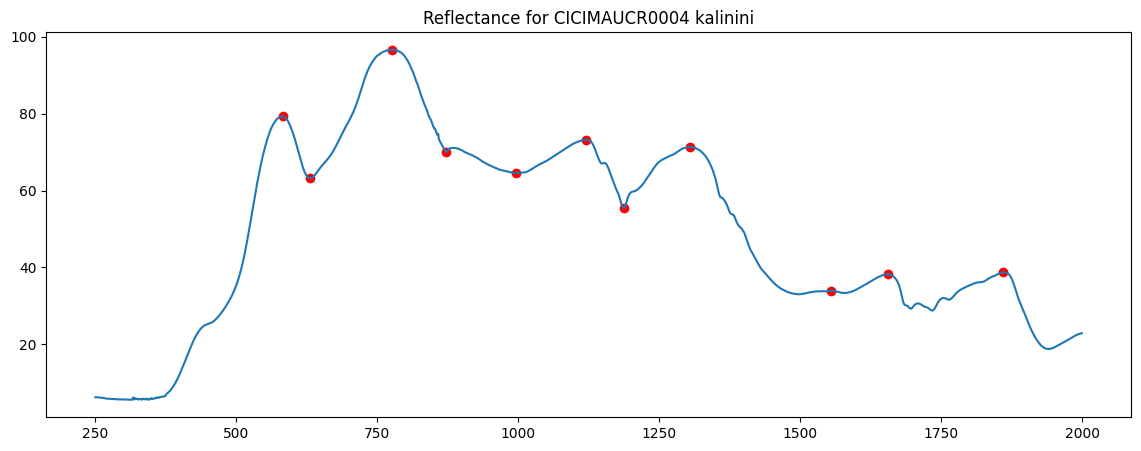

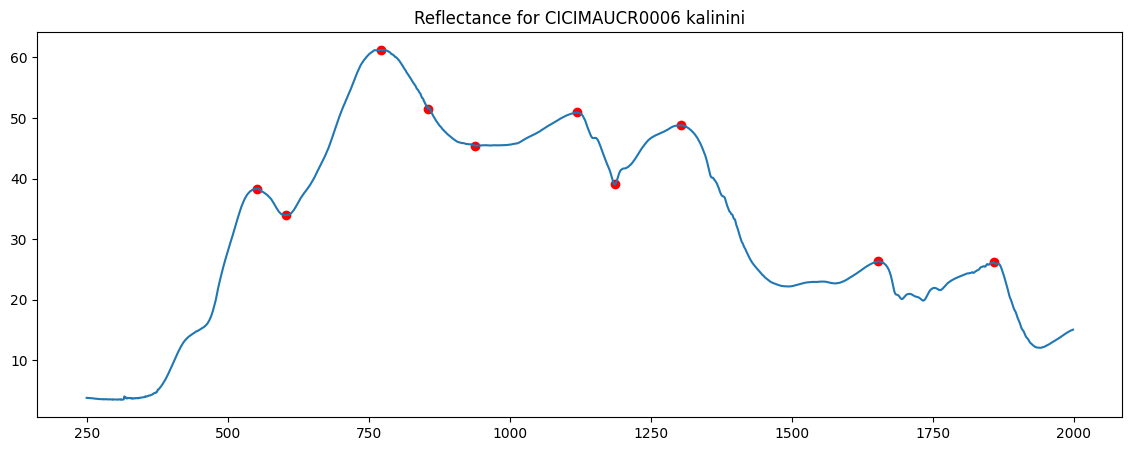

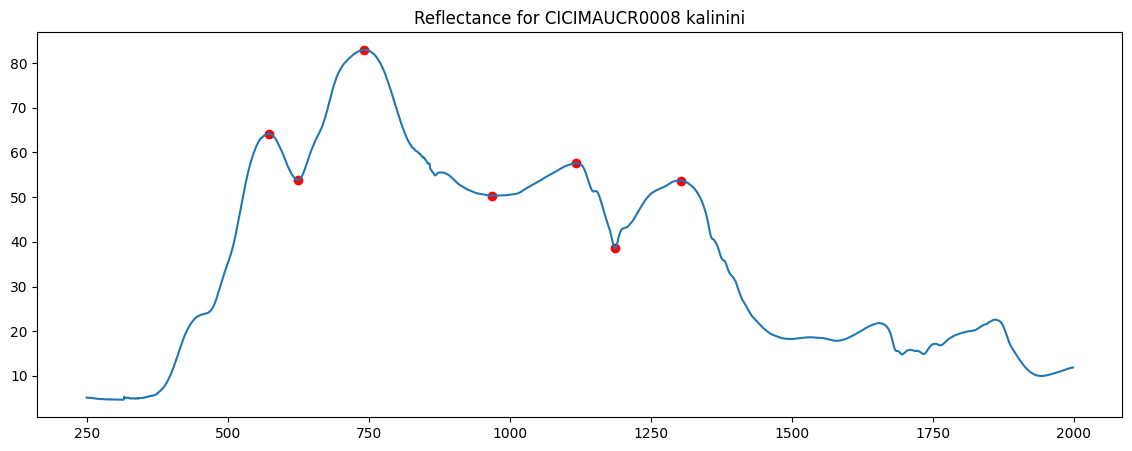

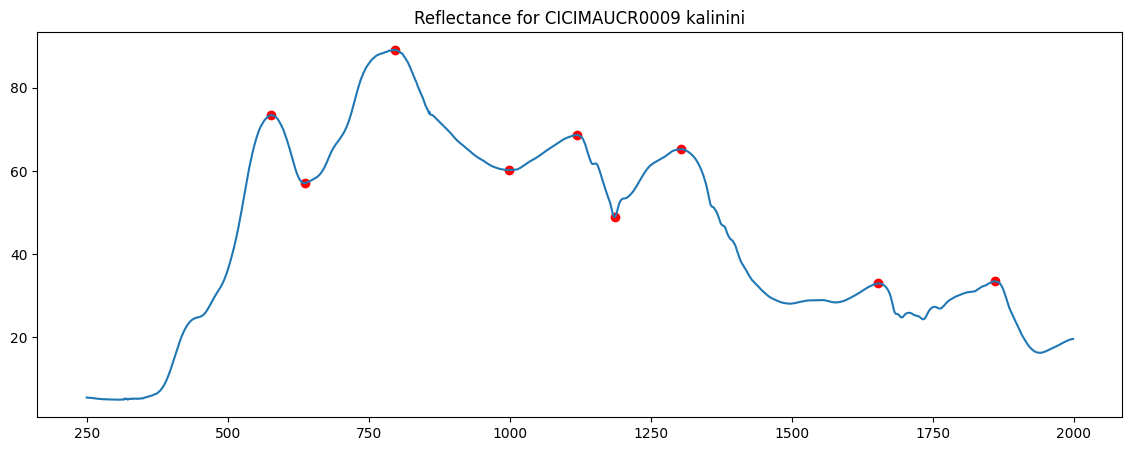

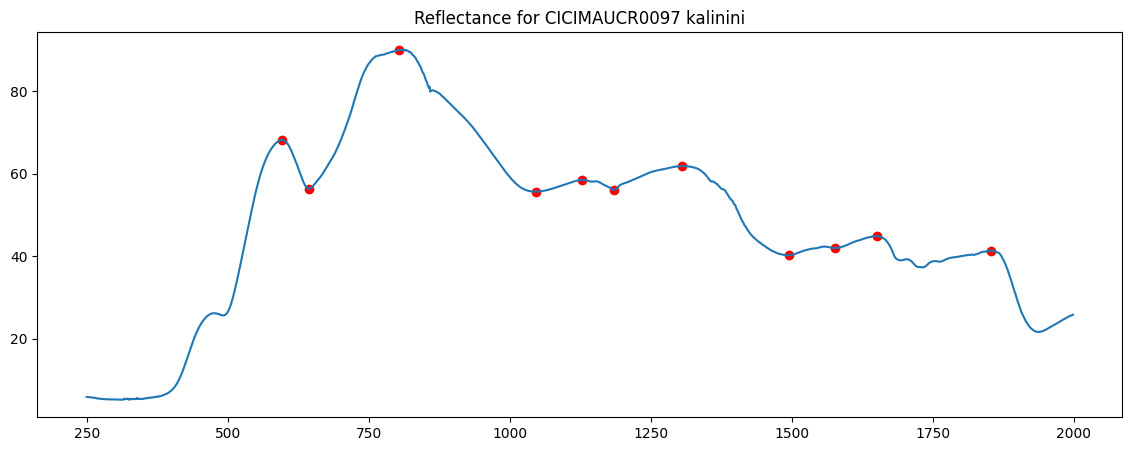

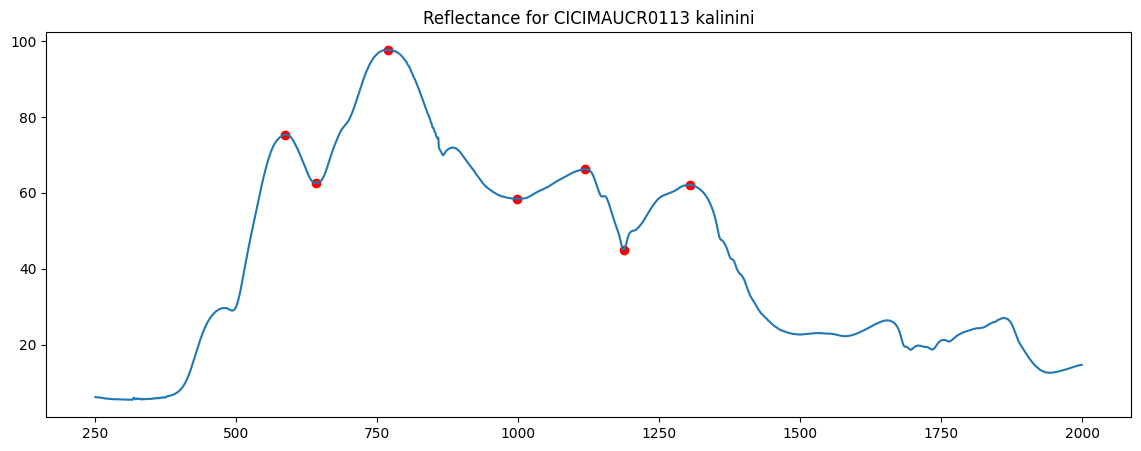

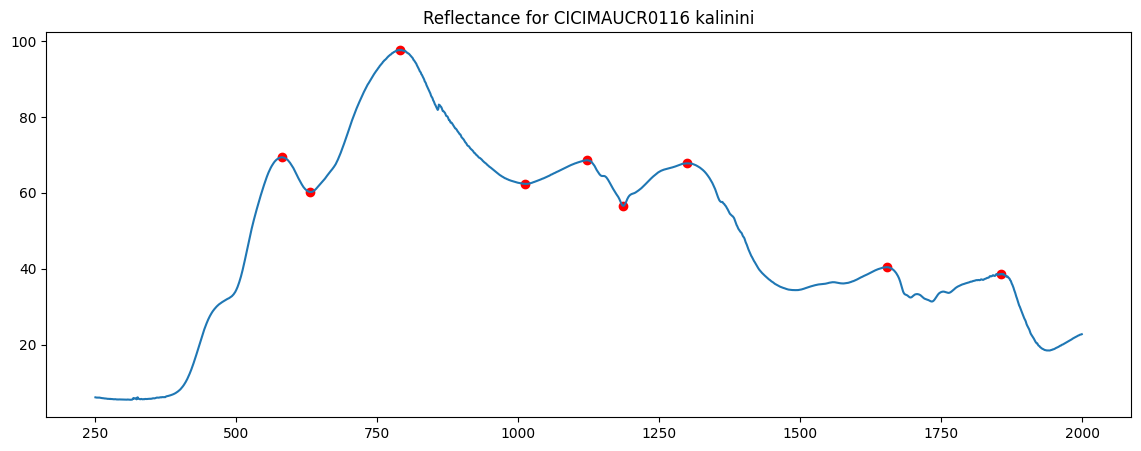

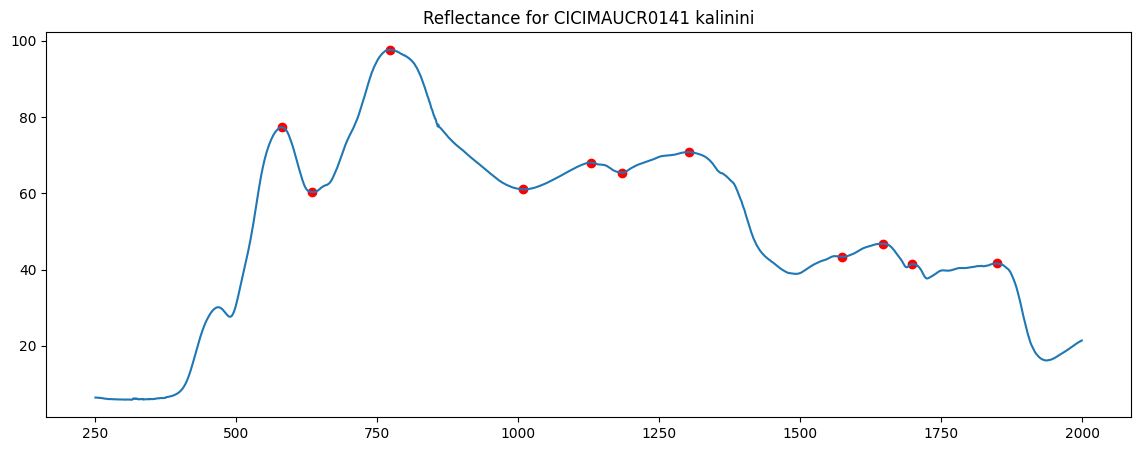

In [28]:
### Define species list
species_list = ["kalinini","resplendens", "cupreomarginata"]
kalinini_specimens = [item for item in training_spectra if item.species == "kalinini"]

for spectrum  in kalinini_specimens:
    plt.figure(figsize = (14,5))
    PeakList(spectrum).plot_settings()
    plt.title(f"Reflectance for {spectrum.code} {spectrum.species}")
    #plt.show()

#Debería sacar

In [22]:

### Training data 
scalar_metrics = [Gamma_Arbitrary_Limits,Gamma_First_Two_Peaks,Gamma_Area_Under_Curve_Naive, Gamma_Area_Under_Curve_First_Min_Cut]
#scalar
gamma_arbitrary_limits_data = feature_and_label_extractor(Gamma_Arbitrary_Limits, training_spectra)
gamma_first_two_peaks_data = feature_and_label_extractor(Gamma_First_Two_Peaks, training_spectra)
gamma_area_under_curve_data = feature_and_label_extractor(Gamma_Area_Under_Curve_Naive, training_spectra)
gamma_area_under_curve_first_min_cut_data = feature_and_label_extractor(Gamma_Area_Under_Curve_First_Min_Cut, training_spectra)

#vectorial
vectorial_metrics = [Wavelength_Vector, Maximum_Points, Minimum_Points, Maximum_Points_Normalized, Minimum_Points_Normalized, Critical_Points ]

gamma_vector_relative_reflectance_data = feature_and_label_extractor(Gamma_Vector_Relative_Reflectance, training_spectra)
wavelength_vector_data = feature_and_label_extractor(Wavelength_Vector, training_spectra)
critical_points_data = feature_and_label_extractor(Critical_Points, training_spectra)

maximum_points_data = feature_and_label_extractor(Maximum_Points, training_spectra)
minimum_points_data = feature_and_label_extractor(Minimum_Points, training_spectra)
maximum_points_normalized_data =feature_and_label_extractor(Maximum_Points_Normalized, training_spectra)
minimum_points_normalized_data =feature_and_label_extractor(Minimum_Points_Normalized, training_spectra)


C:\Users\esteb\cicima\escarabajos\gamma\metrics.py:167: RuntimeWarning: invalid value encountered in scalar divide
  metric = area_ir/area_uv_visible


IndexError: index 0 is out of bounds for axis 0 with size 0

In [20]:
def vector_aggregate(data):
    
    length = len(data[0])

    data_points = []

    #for each specimen get the code, vector metric and species
    
    for i in range(0, length): 
        code = data[0][i]
        vector = data[1][i]
        species =data[2][i]

        data_point = {}
        data_point["code"] = code
        data_point["vector"] = vector
        data_point["species"] = species

        data_points.append(data_point)
    #Print info 
    print(f"{data_points}")
    
    #Now, for each species 
    aggregates = {}
    
    for species in ["kalinini", "resplendens", "cupreomarginata"]:
        
        specimens = [x for x in data_points if x["species"] == species]

        #extract vectors
        vectors = [element["vector"] for element in specimens]

        #first entry
        vector_first_entries =  [element[0] for element in vectors]
        vector_second_entries =  [element[1] for element in vectors]
        
        #get max length of 
        print(type(vector_first_entries[0]))
        if not isinstance((vector_first_entries[0]), np.float64):
            max_length_x = max([len(x) for x in vector_first_entries])
            max_length_y = max([len(x) for x in vector_second_entries])
        else:
            max_length_x = 1
            max_length_y = 1
        
        #get number of vectors
        number_of_specimens = len(specimens)
        
        #add zeroes
        #for first entry
        
        new_subset_vectors = []
        
        new_vector_first_entry = []
        for first_entry_i in vector_first_entries:
            #for the first and second entry
            if isinstance(first_entry_i, np.float64):
                length_first_entry = 1
                number_of_zeroes = max_length_x - length_first_entry
                extend_vector = np.array([0]*number_of_zeroes)
                #print(extend_vector)
                #print(first_entry_i)
                first_entry_i = np.concatenate(([first_entry_i], extend_vector))
                new_vector_first_entry.append(first_entry_i)
            else:
                length_first_entry = len(first_entry_i)
                number_of_zeroes = max_length_x - length_first_entry
                extend_vector = np.array([0]*number_of_zeroes)
                #print(extend_vector)
                #print(first_entry_i)
                first_entry_i = np.concatenate((first_entry_i, extend_vector))
                new_vector_first_entry.append(first_entry_i)

        new_vector_second_entry =  []
        
        for second_entry_i in vector_second_entries:
            #for the first and second entry
            if isinstance(second_entry_i, np.float64):
                length_second_entry = 1
                number_of_zeroes = max_length_x - length_second_entry
                extend_vector = np.array([0]*number_of_zeroes)
                second_entry_i = np.concatenate(([second_entry_i], extend_vector))
                new_vector_second_entry.append(second_entry_i)
            else:
                length_second_entry = len(second_entry_i)
                number_of_zeroes = max_length_x - length_second_entry
                extend_vector = np.array([0]*number_of_zeroes)
                second_entry_i = np.concatenate((second_entry_i, extend_vector))
                new_vector_second_entry.append(second_entry_i)
        #print(f"{new_vector_first_entry=}")
        #print(f"{new_vector_second_entry=}")

        #now calculate averages 

        x_averages = []
        x_std = []
        for i in range(max_length_x): 
            vector_i = []

            for n in range(0, number_of_specimens):
                value_n = new_vector_first_entry[n][i]
                if not( (value_n < 0.1) & (value_n > -0.1) ) : #if value is not zero
                    vector_i.append(value_n)
            #then get the total of elements, convert it into a numpy array , calculate the average. 
            x_averages.append(np.mean(np.array(vector_i)))
            x_std.append(np.std(np.array(vector_i)))
            
        y_averages =[]
        y_std = []
        
        for i in range(max_length_y): 
            vector_x = []
            for n in range(0, number_of_specimens):
                value_n = new_vector_second_entry[n][i]
                if not( (value_n < 0.1) & (value_n > -0.1) ) : #if value is not zero
                    vector_x.append(value_n)
            #then get the total of elements, convert it into a numpy array , calculate the average. 
            y_averages.append(np.mean(np.array(vector_x)))
            y_std.append(np.std(np.array(vector_x)))
        
        info = np.array( [x_averages, y_averages, x_std, y_std]).T
        df = pd.DataFrame(info, columns= [f"{species}_x_avg", f"{species}_y_avg", f"{species}_x_std", f"{species}_y_std"])
        aggregates[species] = df
        #print(aggregates)
    df_2 = pd.DataFrame([])
    for element in aggregates:
        df = (aggregates[element])
        df_2 = pd.concat([df, df_2], axis=1)
        #print(df_2)
    return df_2
    

def save_vector_aggregate(metric_class, spectra, agregated_data_location):
    #get metric values for spectra
    data = feature_and_label_extractor(metric_class, spectra)
    #create vector aggregate df
    df = vector_aggregate(data)  
    #create path location
    path_location = os.path.join(agregated_data_location, "metric_avg_std")
    create_path_if_not_exists(path_location)
    path_and_filename = os.path.join( path_location, f'{metric_class.get_name()}')
    #save to csv
    df.to_csv( path_and_filename, index=False, sep = "\t")



In [21]:
for metric in vectorial_metrics: 
    save_vector_aggregate(metric, training_spectra, agregated_data_location)

NameError: name 'vectorial_metrics' is not defined

In [ ]:
#Save averages and std for training data
metrics_list = [Gamma_Arbitrary_Limits, Gamma_First_Two_Peaks, Gamma_Area_Under_Curve_Naive, Gamma_Area_Under_Curve_First_Min_Cut, 
                Gamma_Area_Under_Curve_First_Min_Cut]

for metric in metrics_list:
    save_aggregated_data(metric,training_spectra,agregated_data_location)


In [ ]:
def calculate_accuracy(df):
    #print(f"{species =} \n {df=}" )
    """Accuracy: Percentage of correct guesses. """
    #filter all predictions of that particular species
    
    total_of_predictions = df["prediction"].count()
    #print(f"{total_of_predictions=}" )
    #Now count the amount of actual species
    correct_predictions = df[df["species"] == df["prediction"]]["species"].count()
    #print(f"{correct_predictions=}" )
    #print(f"{total_of_predictions=}" )
    accuracy = correct_predictions/total_of_predictions*100
    #print(f"{accuracy=}" )
    return accuracy

In [ ]:
def calculate_precision(df, species):
    #print(f"{species =} \n {df=}" )
    """Precision: For a given prediction, what percentage is actually for that species. """
    #filter all predictions of that particular species
    filtered_df = df[df["prediction"] == species]
    total_of_predictions = filtered_df["prediction"].count()
    #print(f"{total_of_predictions=}" )
    #Now count the amount of actual species
    
    actual_species = filtered_df[filtered_df["species"] == species]["species"].count()
    precision = actual_species/total_of_predictions*100
    #print(f"{actual_species=}" )
    #print(f"{total_of_predictions=}" )
    
    #print(f"{precision=}" )
    return precision

In [ ]:
def calculate_recall(df, species):
    #print(f"{species =} \n {df=}" )
    """recall: For a given species, what percentage was correctly characterized. """
    #filter all lines of a particular species
    filtered_df = df[df["species"] == species]
    total_of_species = filtered_df["species"].count()
    #print(f"{total_of_species=}" )
    #Count the amount of correct predictions
    correct_predictions = filtered_df[filtered_df["prediction"] == species]["prediction"].count()
    recall = correct_predictions/total_of_species*100
    #print(f"{recall=}" )
    return recall

In [ ]:
list_of_values = []

In [ ]:
class Similarity_Index(Metric):

    def __init__(self, spectrum, metric_class, aggregate_data_dict , species_list, number_of_points, type_of_index = "xy"):
        self.type_of_index = type_of_index
        self.metric_class = metric_class
        metric_class_name = metric_class.get_name()
        self.aggregate_data_df = aggregate_data_dict[metric_class_name]
        #print(self.aggregate_data_df)
        self.number_of_points = number_of_points
        self.species_list = species_list
        self.spectrum = spectrum
        self.spectrum_peaks = metric_class(spectrum).get_metric_value()
        self.metric_value = self.set_metric_value()
        self.type_of_index = type_of_index
        

    def set_metric_value(self):
        def distance(x, x0, sigma_0):
            
            x = float(x)
            x0 = float(x0[0])
            sigma_0 = float(sigma_0[0])
            #Minimal differences
            min_diff_x = (1 /2500)**2 #nanometers
            min_diff_y = (0.0001/100)**2 #reflectance percentages
            min_diff = min(min_diff_x, min_diff_y)
            #numerator = (np.abs(x - x0))
            #denominator = float(sigma_0 + np.abs(x - x0) +0.1)
            #numerator = ((x - x0)**2 + 0.001)
            #print((x - x0)**2/x0**2)
            numerator = ((x - x0)**2/x0**2 + min_diff)
            list_of_values.append((x - x0)**2/x0**2)
            #print(numerator)
            denominator = 1
            
            try:
                index = numerator/denominator
            except:
                return min_diff
            return index
            #def get_gamma_factor(self, spectrum):

        #define variables
        spectrum_peaks = self.spectrum_peaks
        avg_std_df = self.aggregate_data_df
        n = self.number_of_points
        species = self.species_list 
        
        #get first n peaks of the gamma
        x = spectrum_peaks[0][0:n]
        #print("x")
        #print(x)
        y = spectrum_peaks[1][0:n]
    
        #for each species
        similarity_index_ret = {} #define return dict
        
        for spec in species:
            #print(spec)
            
            #print(averages_df.columns)
            x_avg_column_names = [name for name in (avg_std_df.columns) if ("avg" in name) and (spec in name) and ("x" in name) ]
            y_avg_column_names = [name for name in (avg_std_df.columns) if ("avg" in name) and (spec in name) and ("y" in name) ]
            #print(x_avg_column_names)
    
            x_std_column_names = [name for name in avg_std_df.columns if ("std" in name) and (spec in name) and ("x" in name)]
            y_std_column_names = [name for name in avg_std_df.columns if ("std" in name) and (spec in name) and ("y" in name)]
            #print(x_std_column_names)
    
            #load species average values
    
            x_avg = (avg_std_df[x_avg_column_names].dropna().values[0:n])
            y_avg = avg_std_df[y_avg_column_names].dropna().values[0:n]
    
            #load species std values:
            x_std = avg_std_df[x_std_column_names].dropna().values[0:n]
            y_std = avg_std_df[y_std_column_names].dropna().values[0:n]
    
            #for each peak, calculate the distances to the averages x values
            similarity_index_x_species = 1.0
            similarity_index_y_species = 1.0
    
            #calculate similarity_index for 
            
            #print(x, x_avg, x_std)
            for n_i ,n_0, sigma_n_0 in zip(x, x_avg, x_std):
                similarity_index_x_species *= distance(n_i, n_0, sigma_n_0)
                #similarity_index_x_species += 1/distance(n_i, n_0, sigma_n_0)
                
                
            #calculate similarity_index for y
            for n_i ,n_0, sigma_n_0 in zip(y, y_avg, y_std):
                similarity_index_y_species *= distance(n_i, n_0, sigma_n_0)
                #similarity_index_y_species+= 1/distance(n_i, n_0, sigma_n_0)

         
            
            #arithmetic average
            #similarity_index_x_species = similarity_index_x_species*(1/ float(n) )
            #similarity_index_y_species = similarity_index_y_species*(1/ float(n) )
            
            #geometric average
            #similarity_index_x_species = similarity_index_x_species**(1/ float(n) )
            #similarity_index_y_species = similarity_index_y_species**(1/ float(n) )
            
            #Calculate harmonic average
            #similarity_index_x_species = 1/similarity_index_x_species
            #similarity_index_y_species = 1/similarity_index_y_species

            # Inverses
            #similarity_index_x_species = float(n)/(similarity_index_x_species)
            #similarity_index_y_species = 1/(similarity_index_y_species)
            #add to dictionary
            similarity_index_ret[spec] =[(similarity_index_x_species), (similarity_index_y_species)]

        if self.type_of_index == 0:
            return similarity_index_ret
        elif self.type_of_index == "xy":
            return {item: np.log(similarity_index_ret[item][0]+similarity_index_ret[item][1]) for item in species}
        elif self.type_of_index == "x":
            return {item: np.log(similarity_index_ret[item][0]) for item in species}
        elif self.type_of_index == "y":
            return {item: np.log(similarity_index_ret[item][1]) for item in species}
        
    def __repr__(self):
        return f'Similarity index: {self.metric_value} for {self.spectrum.genus} {self.spectrum.species} in {self.spectrum.filename}'

    @classmethod
    def get_similarity_index_df(self, spectra, metric_class, aggregate_data_dict, species_list, number_of_points):
        # get similarity index
        sim_ind_dict = {"si_kalinini": [], "si_resplendens":[], "si_cupreomarginata":[], "species":[], "code":[]}
        
        for spectrum in spectra:
            sim_indx = Similarity_Index(spectrum= spectrum, metric_class = metric_class,
                                            aggregate_data_dict= aggregate_data_dict , species_list = species_list, 
                                            number_of_points= number_of_points)
            metric_value = sim_indx.get_metric_value()
            sim_ind_dict["si_kalinini"].append(metric_value["kalinini"]) 
            sim_ind_dict["si_resplendens"].append(metric_value["resplendens"]) 
            sim_ind_dict["si_cupreomarginata"].append(metric_value["cupreomarginata"])
            sim_ind_dict["species"].append(sim_indx.spectrum.species)
            sim_ind_dict["code"].append(sim_indx.spectrum.code)
        sim_ind_df = pd.DataFrame(sim_ind_dict)
        return sim_ind_df

In [ ]:
def get_stats_for_metric(metric_list, spectra, avg_std_df, number_of_points = 1 ):
    real_species = ([item.species for item in spectra]) #List of the correct species

    return_df = pd.DataFrame([])
    
    for metric_class in metric_list:
        #get metric name
        metric_name = metric_class.get_name()
        #print(metric_name)
        
        #get metric predictions
        #get similarity index df
        sim_ind_df = Similarity_Index.get_similarity_index_df(spectra,metric_class,avg_std_df ,species_list, number_of_points)
        #print(f"{sim_ind_df=}")
        #get a list of dictionaries with scores for each species 
        score_list = []
        for i in range(0, sim_ind_df.shape[0]):
            results = {"kalinini": sim_ind_df.loc[i]["si_kalinini"], 
                       "resplendens": sim_ind_df.loc[i]["si_resplendens"],  
                       "cupreomarginata": sim_ind_df.loc[i]["si_cupreomarginata"]}
            score_list.append(results)
        #get lowest score
        #print(f"{score_list=}")
        predictions = []
        for element in score_list:
            #print(element)
            result = min(element, key=element.get)
            predictions.append(result)
        #print(f"{predictions=}")
        
        #create dataframe with predictions and real species 
        species_and_predictions_df = pd.DataFrame(np.array([real_species, predictions]).T, columns=["species","prediction"] ) 
        print(species_and_predictions_df)
        
        stats = {}
        stats["metric"] = metric_name
        #calculate accuracy
        accuracy = calculate_accuracy(species_and_predictions_df)
        stats["accuracy"] = accuracy
        
        #for each species, get column names and recall and precision
        for species in species_list:
            stats[f"{species}_recall"] =calculate_recall(species_and_predictions_df, species)
            stats[f"{species}_precision"] =calculate_precision(species_and_predictions_df, species)
        #save stats
        #create empty dataframe
        stats_df = pd.DataFrame([stats]) 
        #print(stats_df)
        return_df = pd.concat([return_df,stats_df]) 
    #print(return_df)
    return return_df
    
avg_std_location = os.path.join(agregated_data_location, "metric_avg_std")
avg_std_df= read_aggregated_data(avg_std_location)
met_list = [Critical_Points, Maximum_Points, Maximum_Points_Normalized, Minimum_Points, Minimum_Points_Normalized]
#met_list = [Critical_Points]

pd.options.display.float_format = '{:.2f}'.format
get_stats_for_metric(met_list, training_spectra, avg_std_df, number_of_points = 1 )

In [ ]:
get_stats_for_metric(met_list, training_spectra, avg_std_df, number_of_points = 2 )

In [ ]:
get_stats_for_metric(met_list, training_spectra, avg_std_df, number_of_points = 3 )


In [ ]:
get_stats_for_metric(met_list, training_spectra, avg_std_df, number_of_points = 4 )


In [ ]:
get_stats_for_metric(met_list, training_spectra, avg_std_df, number_of_points = 5 )

In [ ]:
get_stats_for_metric(met_list, training_spectra, avg_std_df, number_of_points = 6 )

In [ ]:
get_stats_for_metric(met_list, training_spectra, avg_std_df, number_of_points = 7 )

## Metric: Maximum_Points_Normalized
### Just wavelength
#### first metric:  ((x - x0)**2) arith avg
accuracy=46.42857142857143
kalinini
recall=0.0
precision=nan


resplendens
recall=63.63636363636363
precision=43.75


cupreomarginata
recall=75.0
precision=50.0


### Just reflectance
#### first metric:  ((x - x0)**2) arith avg
accuracy=57.14285714285714
kalinini
recall=88.88888888888889
precision=80.0


resplendens
recall=18.181818181818183
precision=40.0


cupreomarginata
recall=75.0
precision=46.15384615384615
#### second metric: ((x - x0)**2) geo avg
accuracy=32.142857142857146
kalinini
recall=100.0
precision=32.142857142857146


resplendens
recall=0.0
precision=nan


cupreomarginata
recall=0.0
precision=nan
#### third metric:  numerator = (np.abs(x - x0)) geometric avg
        denominator = float(sigma_0 + np.abs(x - x0) +0.1)

accuracy=32.142857142857146
kalinini
recall=100.0
precision=32.142857142857146


resplendens
recall=0.0
precision=nan


cupreomarginata
recall=0.0
precision=nan


### Multipliying wavelength and reflectance
#### first metric:  
numerator = float(np.abs(x - x0))
denominator = float(sigma_0 + np.abs(x - x0) +1)

accuracy=50.0
kalinini
recall=0.0
precision=nan


resplendens
recall=90.9090909090909
precision=43.47826086956522


cupreomarginata
recall=50.0
precision=80.0


#### second metric ((x - x0)**2) arith avg (mejores)

accuracy=64.28571428571429
kalinini
recall=55.55555555555556
precision=100.0


resplendens
recall=63.63636363636363
precision=63.63636363636363


cupreomarginata
recall=75.0
precision=50.0



#### third metric ((x - x0)**2) geometric avg

kalinini
accuracy=53.57142857142857
recall=22.22222222222222
precision=66.66666666666666
resplendens
accuracy=53.57142857142857
recall=72.72727272727273
precision=47.05882352941176
cupreomarginata
accuracy=53.57142857142857
recall=62.5
precision=62.5

#### fourth metric abs((x - x0)) arith avg

kalinini
accuracy=53.57142857142857
recall=22.22222222222222
precision=66.66666666666666
resplendens
accuracy=53.57142857142857
recall=72.72727272727273
precision=47.05882352941176
cupreomarginata
accuracy=53.57142857142857
recall=62.5
precision=62.5

### Conclusions: 
(x-x0)**2 and arith avg gives the best accuracies. Now reflectance allows us to detect kalinini.

#print(critical_points_data)
pad_list(critical_points_data, filler = np.array([0,0]))
pad_list(gamma_vector_relative_reflectance_data)
data = pad_list(wavelength_vector_data)

data

# Models

### Functions

In [ ]:
import sys

print(sys.version_info)

from tensorflow.keras import layers

# The following lines adjust the granularity of reporting. 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

# The following line improves formatting when ouputting NumPy arrays.
np.set_printoptions(linewidth = 200)

def replace_strings_3(lst):
    mapping = {"kalinini": 0, "resplendens": 1, "cupreomarginata": 2}
    return [mapping.get(item, item) for item in lst]

def replace_species_with_categorical(df):
    
    df.loc[df["species"]=="kalinini","species"] = 0
    df.loc[df["species"]=="resplendens", "species"] = 1
    df.loc[df["species"]=="cupreomarginata", "species"] = 2
    
    return df
    
def plot_curve(epochs, hist, list_of_metrics):
  """Plot a curve of one or more classification metrics vs. epoch."""  
  # list_of_metrics should be one of the names shown in:
  # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics  

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

print("Loaded the plot_curve function.")

def transpose_list(lst):
    return list(zip(*lst))
    
def get_nth_feature(data, n):
    feature_vector = [data[0], [x[n] for x in data[1]] , data[2]] 
    return feature_vector
def scatter_plot_2_variables(df_1, df_2):

    joint_df = pd.merge(df_1, df_2, on=["code", "species"], how="inner")
    column_list = joint_df.columns.tolist()
    print(column_list)
    column_list = [x for x in column_list if x not in ["code", "species"] ]
    print(column_list)
    plt.figure()
    sns.scatterplot(joint_df, x=column_list[0], y =column_list[1], hue="species")
    plt.show()
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np


def scatter_plot_3_variables(df_1, df_2, df_3):
    
    joint_df = pd.merge(df_1, df_2, on=["code", "species"], how="inner")
    joint_df = pd.merge(joint_df, df_3, on=["code", "species"], how="inner")
    
    column_list = joint_df.columns.tolist()
    print(column_list)
    column_list = [x for x in column_list if x not in ["code", "species"] ]
    print(column_list)
    
    x = joint_df[column_list[0]]
    y = joint_df[column_list[1]]
    z = joint_df[column_list[2]]
    species = joint_df["species"]
    
    # Create color map
    colors = {'kalinini': 'r', 'resplendens': 'g', 'cupreomarginata': 'b'}
    
    # Create figure and 3D axis
    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot points with color based on the fourth dimension
    for category in set(species):
        indices = species == category
        ax.scatter(x[indices], y[indices], z[indices], c=colors[category], label=category, marker='o')
    
    # Set labels and title
    ax.set_xlabel(f'{column_list[0]}')
    ax.set_ylabel(f'{column_list[1]}')
    ax.set_zlabel(f'{column_list[2]}')
    #ax.set_title('3D Scatter plot with species based on Fourth Dimension')
    
    # Add legend
    ax.legend()
    
    plt.show()
def normalize_df(df):
    columns = df.columns
    df2 = pd.DataFrame([])
    for col in columns:
        # Method 1: Min-Max scaling
        min_value = df[col].min()
        max_value = df[col].max()
        #df2[f"{col}"] = (df[col] - min_value) / (max_value - min_value)
        
        # Method 2: Z-score normalization
        mean_value = df[col].mean()
        std_dev = df[col].std()
        df2[f"{col}"] = (df[col] - mean_value) / std_dev
    return df2
def get_spectra_df(spectra):
    #Variables
    min_wavelength = 300
    max_wavelength = 1500
    #Columns are: code, species, x_1, x_2, ..., x_n, y_1, ..., y_n
    feature_column_list = ["code", "species"]
    
    #for i in range(min_wavelength, max_wavelength):
    #    feature_column_list.append(f"x_{i}")
    for i in range(min_wavelength, max_wavelength):   
        feature_column_list.append(f"y_{i}") 
    
    spectrum_df = pd.DataFrame([], columns=feature_column_list)
    #print(f"{len(feature_column_list)}")
    new_row_df =  pd.DataFrame([], columns=feature_column_list)
    
    for spectrum in spectra:
        data = spectrum.get_data()
        data = data[(data["wavelength"]>=min_wavelength) & (data["wavelength"] < max_wavelength)]
        #print(data)
        species = spectrum.get_species()
        code = spectrum.get_code()
        code_species = np.array([code, species])
        #x = data["wavelength"].values
        y = data["%R"].values
        z = np.concatenate((code_species,y))
        #z = y
        #print(len(z))
        new_row_df = pd.DataFrame([z], columns=feature_column_list)
        # Append the new row DataFrame to the existing DataFrame
        spectrum_df = pd.concat((spectrum_df, new_row_df)) 
    return spectrum_df.reset_index().drop("index", axis=1)
    




## Training Data


In [ ]:
def get_training_and_test_df(complete_df):
    complete_df = replace_species_with_categorical(complete_df)
    
    print(f"{complete_df=}")

    #shuffle_df
    shuffled_df = complete_df.sample(frac=1, random_state=87)  # Random_state for reproducibility

    # Define the fraction of data to be used for training
    train_fraction = 0.66  # For example, 80% for training, 20% for testing

    # Calculate the number of rows for the training set
    train_size = int(train_fraction * len(complete_df))

    # Split the shuffled DataFrame into train and test sets
    train_data = shuffled_df.iloc[:train_size]
    test_data = shuffled_df.iloc[train_size:]
    #print(f"{train_data=}")
    #print(f"{test_data=}")
    
    # Split the train and test sets into features and labels
    train_data_features = train_data.drop(columns=['species'], inplace=False)
    train_data_labels =  train_data["species"].copy()
    test_data_features =  test_data.drop(columns=['species'], inplace=False)
    test_data_labels =  test_data["species"].copy()
    
    print(f"{train_data_features=}")
    #print(f"{train_data_labels=}")
    #print(f"{test_data_features=}")
    #print(f"{test_data_labels=}")
    
    

    #normalize features

    #train_data_features_normalized = normalize_df(train_data_features)
    #test_data_features_normalized = normalize_df(test_data_features)
    #print(f"{train_data_features_normalized=}")
    #print(f"{test_data_features_normalized=}")
   

    from tensorflow.keras.utils import to_categorical
    
    train_data_labels_one_hot = to_categorical(train_data_labels, num_classes=3)
    test_data_labels_one_hot = to_categorical(test_data_labels, num_classes=3)

    #train_data_features_normalized = train_data_features_normalized.astype(float)
    #test_data_features_normalized = test_data_features_normalized.astype(float)
    train_data_features_normalized = train_data_features
    test_data_features_normalized = test_data_features
    return train_data_features_normalized,train_data_labels_one_hot, test_data_features_normalized, test_data_labels_one_hot

#print(train_data[train_data_labels["species"]==2])
#print(train_data_features[train_data_labels["species"]==0])
#print(len(train_data))
#print(len(test_data))
#print(test_features)
#print(test_labels)


#drop unwanted cols

#test_data_features_normalized =  test_data_features_normalized.drop(columns=columns_to_drop, inplace=False)


#print(train_data_features_normalized)
#print(train_data_labels[train_data_labels["species"]==0])
#print(train_data_labels_one_hot[train_data_labels["species"]==0])





In [ ]:
#read averages and std
avg_std_location = os.path.join(agregated_data_location, "metric_avg_std")
avg_std_dict = read_aggregated_data(avg_std_location)
#print(avg_std_dict)
column_list = ["code", "species"]
feature_column_list = []

#select features
min_wavelength, max_wavelength = 300, 2000

#for i in range(min_wavelength, max_wavelength):
#    feature_column_list.append(f"x_{i}")
for i in range(min_wavelength, max_wavelength):   
    feature_column_list.append(f"y_{i}") 
        
features_dictionary = {1:["g_arbitrary_limits"] ,2:["g_first_2_peaks"],3:["g_area_und_curve_first_min"], 
                       4: ["g_area_und_curve"], 5: feature_column_list, 6: ["si_kalinini", "si_resplendens", "si_cupreomarginata"]}
selected_features_vector = [1]

for element in selected_features_vector:
    column_list += features_dictionary[element]
print(column_list)

#Training data. Define dataframes

gal_df = pd.DataFrame(transpose_list(gamma_arbitrary_limits_data), columns =["code", "g_arbitrary_limits", "species"]) 
gftp_df = pd.DataFrame(transpose_list(gamma_first_two_peaks_data), columns =["code", "g_first_2_peaks", "species"])
gaucfmc_df = pd.DataFrame(transpose_list(gamma_area_under_curve_first_min_cut_data), columns =["code", "g_area_und_curve_first_min", "species"]) 
gauc_df = pd.DataFrame(transpose_list(gamma_area_under_curve_data), columns =["code", "g_area_und_curve", "species"])
spectra_df = get_spectra_df(training_spectra)
sim_ind_df  = Similarity_Index.get_similarity_index_df(spectra= training_spectra, metric_class = Maximum_Points_Normalized, aggregate_data_dict= avg_std_dict, species_list= species_list, number_of_points=3)  

complete_df = pd.merge(gal_df, gftp_df, on=["code", "species"], how="inner")
complete_df = pd.merge(complete_df, sim_ind_df, on=["code", "species"], how="inner")

#complete_df = spectra_df
print(complete_df)


### Model 3

#### Define inputs

In [ ]:
train_data_features, train_data_labels_one_hot, test_data_features, test_data_labels_one_hot = get_training_and_test_df(complete_df)
train_data_features = train_data_features.drop(["code"], axis= 1).astype(float)
test_data_features = test_data_features.drop(["code"], axis= 1).astype(float)
#print(train_data_features)

input_len = len(train_data_features.columns)
learning_rate = 1e-3
epochs = 220
batch_size = 1
validation_split = 0.05



In [ ]:
print(train_data_features)
print(test_data_features)

#### Define model

#### 


from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import TensorBoard
import datetime


# Set up TensorBoard callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

my_model = create_model_3(learning_rate)
train_and_test(model=my_model, learning_rate= learning_rate, epochs= epochs, batch_size=batch_size, validation_split = validation_split,
               input_x = train_data_features, input_y = train_data_labels_one_hot, eval_x = test_data_features, eval_y = test_data_labels_one_hot)

# Start TensorBoard
%load_ext tensorboard
%tensorboard --logdir logs/fit

In [ ]:
def create_model_3(my_learning_rate):
  """Define the neural net"""
  reg_strength = 0.01
  #Sequential model
  model = tf.keras.models.Sequential()

  # Flatten the input array
  model.add(tf.keras.layers.Flatten(input_shape=(input_len,)))

  # Define the first hidden layer.   
  model.add(tf.keras.layers.Dense(units=10, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_strength)))

  # Define the second hidden layer.   
  model.add(tf.keras.layers.Dense(units=10, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_strength)))

  # Define the third hidden layer.   
  #model.add(tf.keras.layers.Dense(units=6, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_strength)))

  # Define a dropout regularization layer. 
  model.add(tf.keras.layers.Dropout(rate=0.1))

  # Define the output layer. 3 possible species (representing
  # the digits from 0 to 3, inclusive).
  
  model.add(tf.keras.layers.Dense(units=3, activation='softmax'))     
                           
  # Construct the layers into a model that TensorFlow can execute.  
  
  model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
  return model    


def train_model(model, train_features, train_label, epochs,
                batch_size=None, validation_split=0.1):
  """Train the model by feeding it data."""

  
  history = model.fit(x=train_features, y=train_label, batch_size=batch_size,
                      epochs=epochs, shuffle=True)
                      #validation_split=validation_split)
 
  # To track the progression of training, gather a snapshot
  # of the model's metrics at each epoch. 
  epochs = history.epoch
  hist = pd.DataFrame(history.history)

  return epochs, hist    
    
def train_and_test(model, learning_rate, epochs, batch_size, validation_split, input_x, input_y, eval_x, eval_y):
    # The following variables are the hyperparameters.

    # Establish the model's topography.

    # Train the model on the normalized training set.
    epochs, hist = train_model(my_model, input_x, input_y, 
                               epochs, batch_size, validation_split)
    
    # Plot a graph of the metric vs. epochs.
    list_of_metrics_to_plot = ['accuracy']
    plot_curve(epochs, hist, list_of_metrics_to_plot)
    
    # Evaluate against the test set.
    print("\n Evaluate the new model against the test set:")
    my_model.evaluate(x=eval_x, y=eval_y, batch_size=batch_size)



#### Train and Test Model

In [ ]:
#input
my_model = create_model_3(learning_rate)
train_and_test(model=my_model, learning_rate= learning_rate, epochs= epochs, batch_size=batch_size, validation_split = validation_split,
               input_x = train_data_features, input_y = train_data_labels_one_hot, eval_x = test_data_features, eval_y = test_data_labels_one_hot)


In [ ]:
my_model.summary()
#pip install graphviz pydot
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import plot_model
from IPython.display import Image


plot_model(my_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# Display the plot in the notebook
#display(Image(filename='model_plot.png'))


In [ ]:
#Access layer info 
#my_model.layers[2].get_weights()

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

def plot_model_manual(model):
    layers = [layer.name for layer in model.layers]
    connections = []
    for i in range(len(layers)-1):
        connections.append((layers[i], layers[i+1]))

    G = nx.DiGraph()
    G.add_edges_from(connections)
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold', arrows=True)
    plt.show()

#

# Plot the model manually
plot_model_manual(my_model)




### Notas: 
Mejores resultados usando el valor de batch size  4 o 3, acc 0.7
 Para 5, acc baja a 0.6
 Learning rate, buenos resultados en: 0.008-0.009. Acc 0.7
aprendizaje inestable: Cambiamos learning rate a 0.007 y epochs a 600
 Pasar regularización de 0 a 0.1 hace que el aprendizaje sea más suave
 Pasar de 4,4 a 8,4 hace el aprendizaje mas suave
 Pasar de 4,4 a 8,6 hace el aprendizaje menos efectivo
 Pasar de 4,4 a 8,4,4 hace el aprendizaje mas suave
aumentar el validation split de 0.1 a 0.3 reduce el acc a 0.3 0.6 0.6
bajar el validation split 0.1 a 0.05 reduce el acc a 0.5 0.6 0.7
dejar el val. split en 0.1 deja acc en 0.5 0.6 0.65

#### Apply to real data 

In [ ]:
# Prediction data

prediction_gamma_arbitrary_limits_data = feature_and_label_extractor(Gamma_Arbitrary_Limits, prediction_spectra)
prediction_gamma_first_two_peaks_data = feature_and_label_extractor(Gamma_First_Two_Peaks, prediction_spectra)
prediction_gamma_area_under_curve_data = feature_and_label_extractor(Gamma_Area_Under_Curve_Naive, prediction_spectra)
prediction_gamma_area_under_curve_first_min_cut_data = feature_and_label_extractor(Gamma_Area_Under_Curve_First_Min_Cut, prediction_spectra)
prediction_gamma_vector_relative_reflectance_data = feature_and_label_extractor(Gamma_Vector_Relative_Reflectance, prediction_spectra)
prediction_critical_points_data = feature_and_label_extractor(Critical_Points, prediction_spectra)


In [ ]:
#Save model 
from datetime import datetime
date = datetime.today().date()
# Define the file path where you want to save your model
#model_file_path = f'trained_model_{date}.h5'
#model_file_path = f"trained_model_10_e-10_2024-06-05.h5"
model_file_path = f"trained_model_10_e-3_2024-06-05.h5"
# Save the model
my_model.save(model_file_path)

print("Model saved successfully at:", model_file_path)

In [ ]:
# Load the saved model
#model_file_path = f'trained_model_{date}.h5'
#model_file_path = f"trained_model_exitoso_2024-06-01.h5"
#model_file_path = f"trained_model_10_e-10_2024-06-05.h5"
model_file_path = f"trained_model_10_e-3_2024-06-05.h5"
#model_file_path = f"trained_model_6_successful_acc93_2024-06-05.h5"
loaded_model2 = tf.keras.models.load_model(model_file_path)

#load prediction data

#Define dataframe
pred_gal_df = pd.DataFrame(transpose_list(prediction_gamma_arbitrary_limits_data), columns =["code", "g_arbitrary_limits", "species"]) 
pred_gftp_df = pd.DataFrame(transpose_list(prediction_gamma_first_two_peaks_data), columns =["code", "g_first_2_peaks", "species"])
pred_gauc_df = pd.DataFrame(transpose_list(prediction_gamma_area_under_curve_data), columns =["code", "g_area_und_curve", "species"])
pred_gaucfmc_df = pd.DataFrame(transpose_list(prediction_gamma_area_under_curve_first_min_cut_data), columns =["code", "g_area_und_curve_first_min", "species"]) 
pred_sim_ind_df  = Similarity_Index.get_similarity_index_df(metric_class = Maximum_Points, species_list =species_list,number_of_points = 3,  spectra = prediction_spectra, aggregate_data_dict= avg_std_dict)
#pred_spectra_df = get_spectra_df(prediction_spectra)
print(pred_sim_ind_df.drop(["species"], axis = 1))

pred_complete_df = pd.merge(pred_gal_df.drop(["species"],axis=1), pred_gftp_df.drop(["species"],axis=1), on=["code"], how="inner")
print(pred_complete_df)
pred_complete_df = pd.merge(pred_complete_df, pred_sim_ind_df, on=["code"], how="inner").drop(["species", "code"],axis=1)

pred_complete_df



In [ ]:
#Create the prediction features df
prediction_features = pd.DataFrame({name:np.array(value) for name, value in pred_complete_df.items()})

print(prediction_features)
#print(pred_complete_df)

#convert prediction_features to tensor
for element in prediction_features:
    prediction_features[element] = tf.convert_to_tensor(np.array(prediction_features[element]), dtype=tf.int64) 

In [ ]:


# Predict using the loaded model
predictions = loaded_model2.predict(prediction_features)

# Print the predictions
#print(predictions)
prediction_df = pd.DataFrame(predictions, columns=["kalinini", "resplendens", "cupreomarginata"])
prediction_df

In [ ]:
merged_prediction_data = pd.merge(pred_gal_df, pred_gftp_df , on=["code","species"], how="inner")
merged_prediction_data = pd.merge(merged_prediction_data, pred_gauc_df , on=["code","species"], how="inner")
merged_prediction_data = pd.merge(merged_prediction_data, pred_gaucfmc_df , on=["code","species"], how="inner")
merged_prediction_data = pd.merge(merged_prediction_data, pred_sim_ind_df , on=["code","species"], how="inner")
merged_prediction_data

In [ ]:
for spectrum in training_spectra:
    if spectrum.species == "resplendens":
        spectrum.plot()

In [ ]:
df_metricas_3 =pd.DataFrame( [ 
                  ["model_e-3",4/9.0*100, 1.0*100, 0.5*100,0.33*100, 0.00*100, 0.00*100, 0*100],
                ["model_e-10", 7/9.0*100, 1.0*100, 1.0*100, 1*100, 0.6*100, 0.33*100,1.0*100]
                ], columns=["model","accuracy", "kalinini_recall", "kalinini_precision", "resplendens_recall", "resplendens_precision", "cupreomarginata_recall", "cupreomarginata_precision"] ).reset_index()

In [ ]:
df_metricas_3

In [ ]:
[spectrum.get_species() for spectrum in prediction_spectra]

### Comparison with baseline

In [ ]:
get_stats_for_metric(met_list, prediction_spectra, avg_std_df, number_of_points = 4 )

In [ ]:
sorted([x for x in list_of_values if x != 0.0])